Here we test the integration of the Hubble parameter $H(z)$ for the GILA model.

In [1]:
#Import libraries related to BAO data.
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import time
import os
import git

from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz as cumtrapz
from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir

Lets define some functions for the calculations of $H(z)$

In [2]:
def E_LCDM(z, omega_m):
    '''
    Calculation of the normalized Hubble parameter, independent
    of the Hubble constant H0.
    '''
    omega_lambda = 1 - omega_m
    E = np.sqrt(omega_m * (1 + z)**3 + omega_lambda)
    return E

def H_LCDM(z, omega_m, H_0):
    '''
    Calculation of the Hubble parameter.
    Here we neclect the radiation (it holds 
    that \Omega_r + \Omega_m + \Omega_L = 1).
    '''
    H = H_0 * E_LCDM(z, omega_m)
    return H


In [3]:
def F_H(H, params):     
    lamb, L, beta, L_bar = params
    FH = H**2 - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**10) \
              + H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2)
    return FH

def F_H_prime(H, params):
    lamb, L, beta, L_bar = params
    aux = np.exp(-beta*(L_bar*H)**10) * beta * (L_bar*H)**4 * (-3 + 5 * beta * (L_bar*H)**10) +\
          np.exp(lamb*(L*H)**2) * lamb * (L*H)**6 * (4 + lamb*(L*H)**2)
    FH_prime = 2 * H * (1 + aux) 
    return FH_prime

In [4]:
def omega_CDM_to_luisa(beta, L_bar, H0, omega_lcdm):
    factor_inv = H0**2 / F_H(H0, [0, 1e-27/H0, beta, L_bar/H0]) 
    omega_luisa = omega_lcdm * factor_inv
    return omega_luisa

In [5]:

def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'HS'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    #kappa = 8 * np.pi * G_newton / 3
    kappa = 1

    [lamb, L, b, L_bar, H_0, omega_m_0] = params_ode


    #omega_m_0 = 0.999916 #omega_m_0 es el de Luisa
    omega_r_0 = 1 - omega_m_0

    F_H0 = F_H(H_0, [lamb, L, b, L_bar])

    if lcdm == True:
        rho_crit_0 = H_0**2 / kappa        
    else:
        rho_crit_0 = F_H0 / kappa
    #print(omega_m_0,F_H0,rho_crit_0)
    a = 1/(1+z)

    rho_r = rho_crit_0 * omega_r_0 * a**(-4)
    rho_m = rho_crit_0 * omega_m_0 * a**(-3)
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * kappa * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [lamb, L, b, L_bar]))     
    #print(s)
    return s


def integrator_GILA(physical_params, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    
    L_bar, beta, H0, omega_m_GILA = physical_params
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    ode_params = [0, 1e-27/H0, beta, L_bar/H0, H0, omega_m_GILA]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    #assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    #assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

# $\bar{L}=0.9$

In [6]:
# LCDM parameters
H_0 = 70
omega_m = 0.3

# GILA parameters
L_bar = 0.9 #in units of H0
beta = 0.1
omega_m_GILA = omega_CDM_to_luisa(beta, L_bar, H_0, omega_m)


In [7]:
physical_params = [L_bar, beta, H_0, omega_m_GILA]
zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
len(zs_model)

100000

In [8]:
import pandas as pd
from numpy.linalg import inv
# Cosmic Chronometers
def read_data_chronometers(file_chronometers):
    # Read text with data
    z, h, dh = np.loadtxt(file_chronometers, usecols=(0,1,2), unpack=True)
    return z, h, dh

def read_data_pantheon_plus(file_pantheon_plus,file_pantheon_plus_cov):

    '''
    Takes Pantheon+ data and extracts the data from the zhd and zhel 
    redshifts, its error dz, in addition to the data of the apparent magnitude
    with its error: mb and dm. With the errors of the apparent magnitude 
    builds the associated correlation matrix. The function returns the
    information of the redshifts, the apparent magnitude 
    and the correlation matrix inverse.
    '''

    # Read text with data

    data = pd.read_csv(file_pantheon_plus,delim_whitespace=True)
    ww = (data['zHD']>0.01) | (np.array(data['IS_CALIBRATOR'],dtype=bool))

    zhd = data['zHD'][ww]
    zhel = data['zHEL'][ww]
    mb = data['m_b_corr'][ww]

    Ccov=np.load(file_pantheon_plus_cov)['arr_0']
    Cinv=inv(Ccov)

    return zhd, zhel, Cinv, mb


def chi2_supernovae(muth, muobs, C_invertida):
    '''This function estimates the value of the statistic chi squared
    for the Supernovae data.'''
    deltamu = muth - muobs #row vector
    transp = np.transpose(deltamu) #column vector
    aux = np.dot(C_invertida,transp) #column vector
    chi2 = np.dot(deltamu,aux) #scalar
    return chi2

def chi2_sin_cov(teo, data, errors_cuad):
    '''
    Calculate chi square assuming no correlation.

    teo (array): Theoretical prediction of the model.
    data (array): Observational data to compare with the model.
    errors_cuad (array): The square of the errors of the data.

    '''

    chi2 = np.sum((data-teo)**2/errors_cuad)
    return chi2

#%% Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')
[zs_cc, Hs_cc, sigmas_cc] = ds_CC


#%% Pantheon plus
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
zhd, zhel, Cinv, mb = read_data_pantheon_plus('Pantheon+SH0ES.dat',
                        'covmat_pantheon_plus_only.npz')
emu=np.sqrt(np.diag(np.linalg.inv(Cinv)))


# $\Omega_m = 0.52$

Given \Omega_m=0.520 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$
For the LCDM, we have $\chi_2$ = 3179.877254003163
For $\beta$ = 0.1, we have $\chi_2$ = 8059.158487876397
For $\beta$ = 1.0, we have $\chi_2$ = 2918.7726431587357
For $\beta$ = 6.145, we have $\chi_2$ = 1900.8298310092903
For $\beta$ = 10, we have $\chi_2$ = 3352.3507635448036
For $\beta$ = 100, we have $\chi_2$ = 7421.980223046354


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


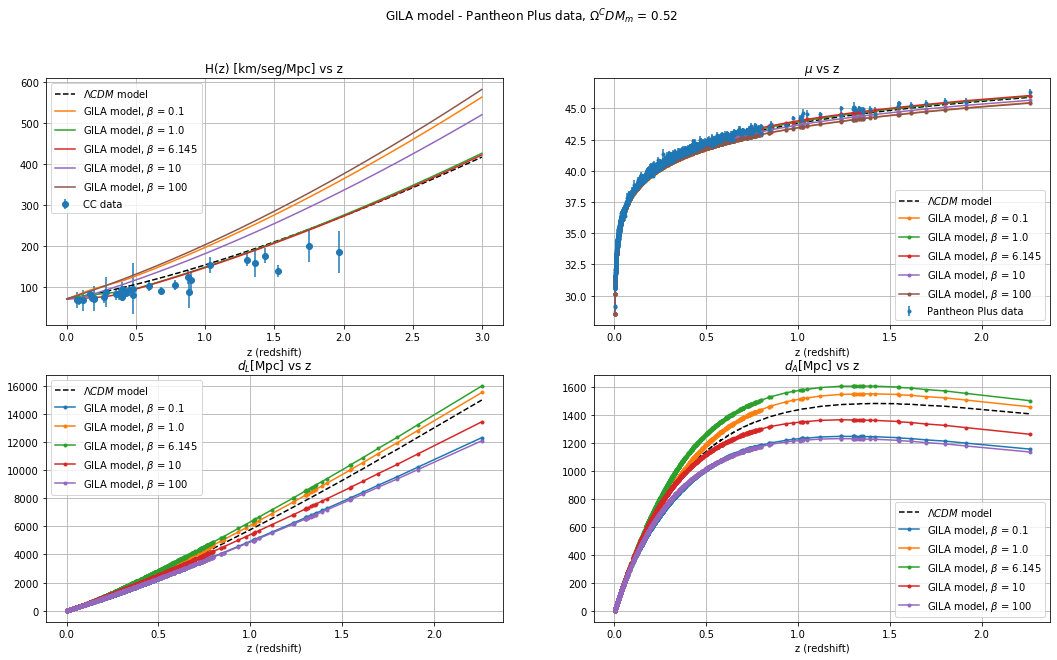

In [9]:
# LCDM parameters
H_0 = 71.905
omega_m = 0.520
Mabs = -19.37

# GILA parameters
L_bar = 0.9 #in units of H0
beta = 6.145
omega_m_GILA = omega_CDM_to_luisa(beta, L_bar, H_0, omega_m)
muobs =  mb - Mabs  

Hs_interpolado = interp1d(zs_model, H_LCDM(zs_model, omega_m, H_0))
int_inv_Hs = cumtrapz(H_LCDM(zs_model, omega_m, H_0)**(-1), zs_model, initial=0)
int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
d_L_lcdm = (1 + zhel) * dc_int
d_A_lcdm = dc_int / (1 + zhel)
muth_lcdm = 25.0 + 5.0 * np.log10(d_L_lcdm)
chi2_lcdm = chi2_supernovae(muth_lcdm, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)


fig, axs = plt.subplots(2,2,figsize=(18,10))
fig.suptitle(r'GILA model - Pantheon Plus data, $\Omega^CDM_m$ = {}'.format(omega_m)), \
            axs[0,0].set_title('H(z) [km/seg/Mpc] vs z'), axs[0,1].set_title('$\mu$ vs z'), \
            axs[1,0].set_title(r'$d_L$[Mpc] vs z'), axs[1,1].set_title(r'$d_A$[Mpc] vs z')
axs[0,0].errorbar(zs_cc, Hs_cc, yerr=sigmas_cc, fmt='o',label='CC data')
axs[0,0].plot(zs_model, H_LCDM(zs_model, omega_m, H_0), 'k--',label=r'$\Lambda CDM$ model')

axs[0,1].plot(zhd, muth_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[0,1].errorbar(zhd,muobs,emu,fmt='.', label='Pantheon Plus data')

axs[1,0].plot(zhd, d_L_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[1,1].plot(zhd, d_A_lcdm, 'k--',label=r'$\Lambda CDM$ model')

print(r'Given \Omega_m=0.520 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$') 
print(r'For the LCDM, we have $\chi_2$ = {}'.format(chi2_lcdm))

for beta in([0.1, 1., 6.145, 10, 100]):
    physical_params = [L_bar, beta, H_0, omega_m_GILA]
    zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
    Hs_interpolado = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
    dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
    d_L = (1 + zhel) * dc_int
    d_A = dc_int / (1 + zhel)
    muth = 25.0 + 5.0 * np.log10(d_L)
    chi2 = chi2_supernovae(muth, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)
    print(r'For $\beta$ = {}, we have $\chi_2$ = {}'.format(beta, chi2))
    axs[0,0].plot(zs_model, Hs_model,label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[0,1].plot(zhd,muth,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,0].plot(zhd,d_L,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,1].plot(zhd,d_A,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))

for ax in axs.reshape(-1): 
  ax.grid()
  ax.set_xlabel('z (redshift)')
  ax.legend()


# $\Omega_m$ = 0.3

Given \Omega_m=0.3 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$
For the LCDM, we have $\chi_2$ = 2075.392831826522
For $\beta$ = 0.1, we have $\chi_2$ = 8817.631869224013
For $\beta$ = 1.0, we have $\chi_2$ = 3130.012325491595
For $\beta$ = 6.145, we have $\chi_2$ = 2018.077241753942
For $\beta$ = 10, we have $\chi_2$ = 3834.8901088581297
For $\beta$ = 100, we have $\chi_2$ = 8236.746499837434


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


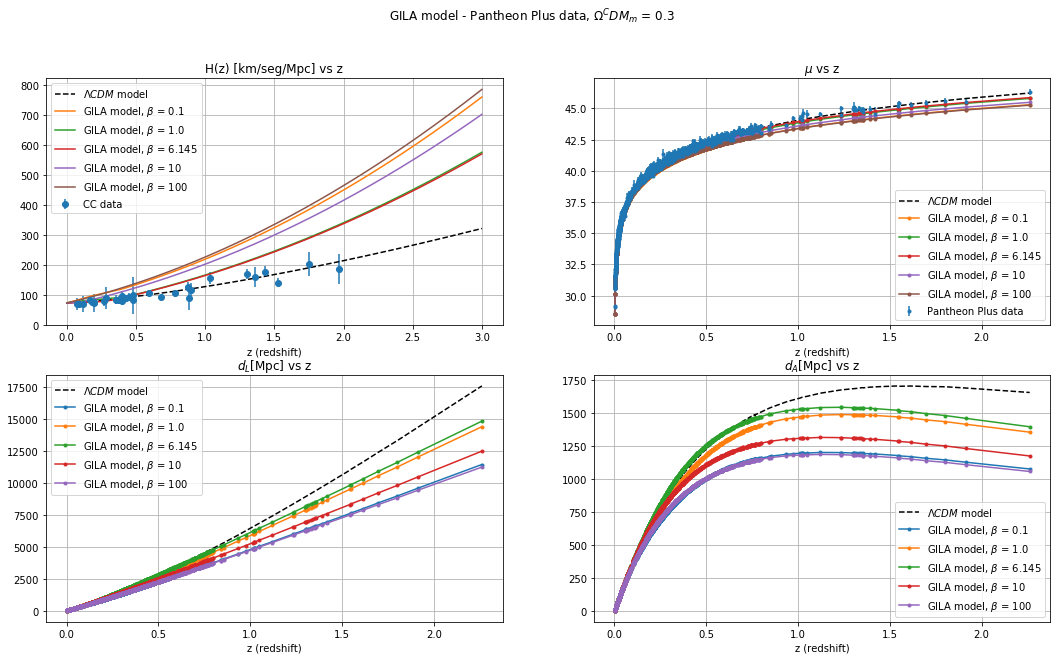

In [10]:
# LCDM parameters
H_0 = 71.905
omega_m = 0.3 #0.27 minimiza mas el chi2 para LCDM
Mabs = -19.37

# GILA parameters
L_bar = 0.9 #in units of H0
beta = 6.145
omega_m_GILA = omega_CDM_to_luisa(beta, L_bar, H_0, omega_m)
muobs =  mb - Mabs  

Hs_interpolado = interp1d(zs_model, H_LCDM(zs_model, omega_m, H_0))
int_inv_Hs = cumtrapz(H_LCDM(zs_model, omega_m, H_0)**(-1), zs_model, initial=0)
int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
d_L_lcdm = (1 + zhel) * dc_int
d_A_lcdm = dc_int / (1 + zhel)
muth_lcdm = 25.0 + 5.0 * np.log10(d_L_lcdm)
chi2_lcdm = chi2_supernovae(muth_lcdm, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)


fig, axs = plt.subplots(2,2,figsize=(18,10))
fig.suptitle(r'GILA model - Pantheon Plus data, $\Omega^CDM_m$ = {}'.format(omega_m)), \
            axs[0,0].set_title('H(z) [km/seg/Mpc] vs z'), axs[0,1].set_title('$\mu$ vs z'), \
            axs[1,0].set_title(r'$d_L$[Mpc] vs z'), axs[1,1].set_title(r'$d_A$[Mpc] vs z')
axs[0,0].errorbar(zs_cc, Hs_cc, yerr=sigmas_cc, fmt='o',label='CC data')
axs[0,0].plot(zs_model, H_LCDM(zs_model, omega_m, H_0), 'k--',label=r'$\Lambda CDM$ model')

axs[0,1].plot(zhd, muth_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[0,1].errorbar(zhd,muobs,emu,fmt='.', label='Pantheon Plus data')

axs[1,0].plot(zhd, d_L_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[1,1].plot(zhd, d_A_lcdm, 'k--',label=r'$\Lambda CDM$ model')

print(r'Given \Omega_m=0.3 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$') 
print(r'For the LCDM, we have $\chi_2$ = {}'.format(chi2_lcdm))

for beta in([0.1, 1., 6.145, 10, 100]):
    physical_params = [L_bar, beta, H_0, omega_m_GILA]
    zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
    Hs_interpolado = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
    dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
    d_L = (1 + zhel) * dc_int
    d_A = dc_int / (1 + zhel)
    muth = 25.0 + 5.0 * np.log10(d_L)
    chi2 = chi2_supernovae(muth, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)
    print(r'For $\beta$ = {}, we have $\chi_2$ = {}'.format(beta, chi2))
    axs[0,0].plot(zs_model, Hs_model,label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[0,1].plot(zhd,muth,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,0].plot(zhd,d_L,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,1].plot(zhd,d_A,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))

for ax in axs.reshape(-1): 
  ax.grid()
  ax.set_xlabel('z (redshift)')
  ax.legend()


# $\Omega_m$ = 0.27

Given \Omega_m=0.27 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$
For the LCDM, we have $\chi_2$ = 1994.7312964320952
For $\beta$ = 0.1, we have $\chi_2$ = 8923.14560075546
For $\beta$ = 1.0, we have $\chi_2$ = 3161.711713770987
For $\beta$ = 6.145, we have $\chi_2$ = 2037.5501737396369
For $\beta$ = 10, we have $\chi_2$ = 3903.7229119723875
For $\beta$ = 100, we have $\chi_2$ = 8349.963513649534


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


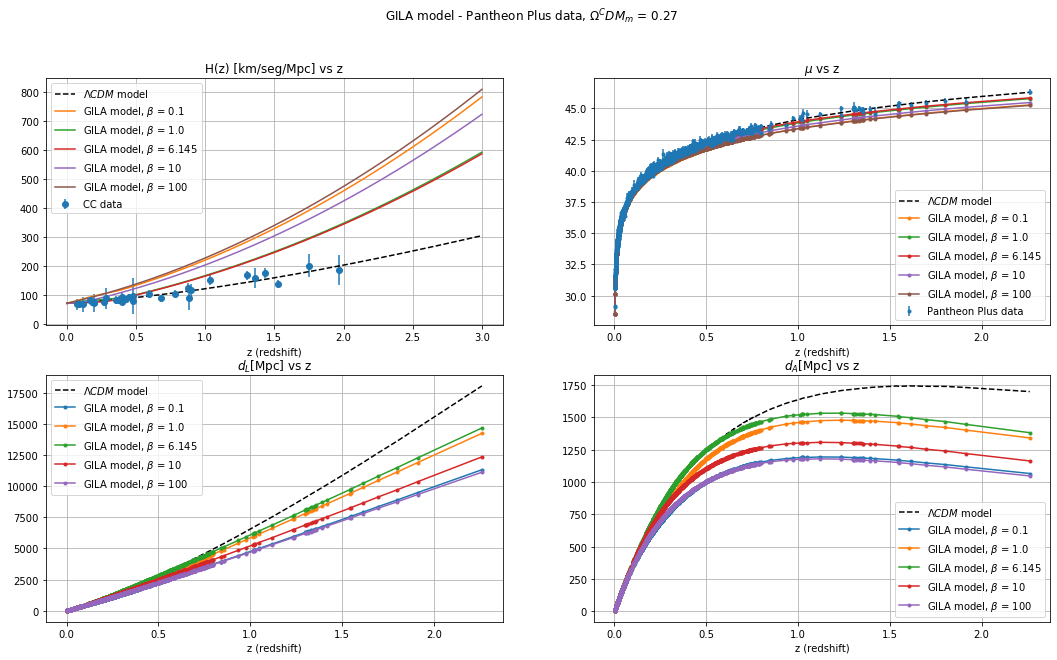

In [11]:
# LCDM parameters
H_0 = 71.905
omega_m = 0.27 #0.27 minimiza mas el chi2 para LCDM
Mabs = -19.37

# GILA parameters
L_bar = 0.9 #in units of H0
beta = 6.145
omega_m_GILA = omega_CDM_to_luisa(beta, L_bar, H_0, omega_m)
muobs =  mb - Mabs  

Hs_interpolado = interp1d(zs_model, H_LCDM(zs_model, omega_m, H_0))
int_inv_Hs = cumtrapz(H_LCDM(zs_model, omega_m, H_0)**(-1), zs_model, initial=0)
int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
d_L_lcdm = (1 + zhel) * dc_int
d_A_lcdm = dc_int / (1 + zhel)
muth_lcdm = 25.0 + 5.0 * np.log10(d_L_lcdm)
chi2_lcdm = chi2_supernovae(muth_lcdm, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)


fig, axs = plt.subplots(2,2,figsize=(18,10))
fig.suptitle(r'GILA model - Pantheon Plus data, $\Omega^CDM_m$ = {}'.format(omega_m)), \
            axs[0,0].set_title('H(z) [km/seg/Mpc] vs z'), axs[0,1].set_title('$\mu$ vs z'), \
            axs[1,0].set_title(r'$d_L$[Mpc] vs z'), axs[1,1].set_title(r'$d_A$[Mpc] vs z')
axs[0,0].errorbar(zs_cc, Hs_cc, yerr=sigmas_cc, fmt='o',label='CC data')
axs[0,0].plot(zs_model, H_LCDM(zs_model, omega_m, H_0), 'k--',label=r'$\Lambda CDM$ model')

axs[0,1].plot(zhd, muth_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[0,1].errorbar(zhd,muobs,emu,fmt='.', label='Pantheon Plus data')

axs[1,0].plot(zhd, d_L_lcdm, 'k--',label=r'$\Lambda CDM$ model')
axs[1,1].plot(zhd, d_A_lcdm, 'k--',label=r'$\Lambda CDM$ model')

print(r'Given \Omega_m=0.27 and L=0.9, we can see that the best value of $\beta$ is 6.145. Let\'s check the $\chi^2$ for the different values of $\beta$') 
print(r'For the LCDM, we have $\chi_2$ = {}'.format(chi2_lcdm))

for beta in([0.1, 1., 6.145, 10, 100]):
    physical_params = [L_bar, beta, H_0, omega_m_GILA]
    zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=3)
    Hs_interpolado = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_model, int_inv_Hs)
    dc_int =  c_light_km * int_inv_Hs_interpolado(zhd)
    d_L = (1 + zhel) * dc_int
    d_A = dc_int / (1 + zhel)
    muth = 25.0 + 5.0 * np.log10(d_L)
    chi2 = chi2_supernovae(muth, muobs, Cinv) + chi2_sin_cov(Hs_interpolado(zs_cc), Hs_cc, sigmas_cc**2)
    print(r'For $\beta$ = {}, we have $\chi_2$ = {}'.format(beta, chi2))
    axs[0,0].plot(zs_model, Hs_model,label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[0,1].plot(zhd,muth,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,0].plot(zhd,d_L,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))
    axs[1,1].plot(zhd,d_A,'.-',label=r'GILA model, $\beta$ = {}'.format(beta))

for ax in axs.reshape(-1): 
  ax.grid()
  ax.set_xlabel('z (redshift)')
  ax.legend()
